## Attention Only Analysis

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [3]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [4]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.float16)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list,dtype=np.float16)
    return sequence_array_list

In [5]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

In [348]:
positive_seqRecords = list(SeqIO.parse('./peak_sequences/c57bl6_kla-1h_peaks.fasta', 'fasta'))
negative_seqRecords = list(SeqIO.parse('./background_files/c57bl6_kla-1h_background.fasta', 'fasta'))[:len(positive_seqRecords)]

fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
    [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
labels = np.array(labels)

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Additive Attention

In [583]:
def get_additiveAttention_model(total_seq_length,
                        seq_size=150,
                        num_motifs=32, 
                        motif_size=10,
                        adjacent_bp_pool_size=10,
                        attention_dim=32,
                        attention_hops=1,
                        num_dense_neurons=32,
                        dropout_rate=0.5):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
    
    ### normalize motif scores ###
    motif_score_norm_layer = BatchNormalization(name='motif_score_norm_layer')
    normed_pooled_scores = motif_score_norm_layer(pooled_scores)
    
    ### bidirectional LSTM ###
    forward_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'forward_lstm_layer'
        )
    forward_hidden_states = forward_lstm_layer(normed_pooled_scores)

    reverse_lstm_layer = LSTM(units=int(seq_size/adjacent_bp_pool_size),
        return_sequences=True,
        input_shape = (int(seq_size/adjacent_bp_pool_size), 2*num_motifs),
        name = 'reverse_lstm_layer',
        go_backwards=True,
        )
    reverse_hidden_states = reverse_lstm_layer(normed_pooled_scores)
    
    ### concatenate lstm hidden states ###
    lstm_concatenate_layer = Concatenate(axis=2)
    bilstm_hidden_states = lstm_concatenate_layer([forward_hidden_states, reverse_hidden_states])
    
    ### normalize lstm states ###
    lstm_norm_layer = BatchNormalization(name='lstm_norm_layer')
    normed_bilistm_hidden_states = lstm_norm_layer(bilstm_hidden_states)
    
    ### attention tanh layer ###
    attention_tanh_layer = Dense(attention_dim,
        activation='tanh',
        use_bias=False,
        name = 'attention_tanh_layer')
    attention_tanh_layer_out = attention_tanh_layer(normed_bilistm_hidden_states)

    ### outer layer ###
    attention_outer_layer = Dense(attention_hops,
        activation='linear',
        use_bias=False,
        name = 'attention_outer_layer')
    attention_outer_layer_out = attention_outer_layer(attention_tanh_layer_out)

    ### apply softmax ###
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_outer_layer_out)

    ### attend to hidden states ###
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')

    attended_states = attending_layer([attention_softmax_layer_out, normed_bilistm_hidden_states])
    
    ### normalize attended states ###
    attention_norm_layer = BatchNormalization(name='attention_norm_layer')
    normed_attended_states = attention_norm_layer(attended_states)
    
    ### fully connected layer ###
    dense_layer = Dense(num_dense_neurons, 
        activation='relu', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(normed_attended_states)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'sigmoid', 
                       )(flattened)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [595]:
additiveAttention_model = get_additiveAttention_model(200,
    seq_size=150,
    num_motifs=100, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    attention_dim=32,
    attention_hops=1,
    num_dense_neurons=32,
    dropout_rate=0.75
    )
additiveAttention_model.count_params()

33110

In [596]:
additiveAttention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
input_rev (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 100)     4100        input_fwd[0][0]                  
                                                                 input_rev[0][0]                  
__________________________________________________________________________________________________
crop_layer (Cropping1D)         (None, 150, 100)     0           convolution_layer[0][0]          
          

In [597]:
additiveAttention_model.fit([x_train, x_rc_train], y_train,
              batch_size=128,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

probs = additiveAttention_model.predict([x_test, x_rc_test])

roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
print(roc, precision, acc)

Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 45s 1ms/step - loss: 0.7142 - acc: 0.5558 - val_loss: 0.6492 - val_acc: 0.6255
Epoch 2/10
34841/34841 [==============================] - 19s 544us/step - loss: 0.6206 - acc: 0.6708 - val_loss: 0.6054 - val_acc: 0.6486
Epoch 3/10
34841/34841 [==============================] - 19s 539us/step - loss: 0.5523 - acc: 0.7293 - val_loss: 0.5022 - val_acc: 0.7572
Epoch 4/10
34841/34841 [==============================] - 19s 542us/step - loss: 0.4980 - acc: 0.7665 - val_loss: 0.5173 - val_acc: 0.7400
Epoch 5/10
34841/34841 [==============================] - 19s 543us/step - loss: 0.4605 - acc: 0.7911 - val_loss: 0.4264 - val_acc: 0.8043
Epoch 6/10
34841/34841 [==============================] - 19s 541us/step - loss: 0.4284 - acc: 0.8121 - val_loss: 0.4223 - val_acc: 0.8006
Epoch 7/10
34841/34841 [==============================] - 19s 538us/step - loss: 0.4036 - acc: 0.8249 - val_loss: 0.401

## Dot Product Attention

In [328]:
def get_dotProductAttention_model(total_seq_length,
    seq_size=150,
    num_motifs=32, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    num_dense_neurons=32,
    dropout_rate=0.5):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)
    #print('forward_motif_scores', forward_motif_scores.get_shape())

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)
    #print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)
    #print('flipped_rev_scores', flipped_rev_scores.get_shape())

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
    #print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
    #print('pooled_scores', pooled_scores.get_shape())
    
    ### normalize motif scores ###
    motif_score_norm_layer = BatchNormalization(name='motif_score_norm_layer')
    normed_pooled_scores = motif_score_norm_layer(pooled_scores)
    #print('normed_pooled_scores', normed_pooled_scores.shape)
        
    ### compute attention ###

    # reshape motif scores
    linear_projection_reshaper = Reshape((int(normed_pooled_scores.shape[1]), 
       int(normed_pooled_scores.shape[2]),1), name='linear_projection_reshaper')
    
    reshaped_normed_pooled_scores = linear_projection_reshaper(normed_pooled_scores)    
    #print('reshaped_normed_pooled_scores', reshaped_normed_pooled_scores.shape)
    
    ### weight queries ###
    query_transformer = Conv2D(filters=1, 
        kernel_size=1,
        activation='linear',
        input_shape=(seq_size/adjacent_bp_pool_size,num_motifs*2),
        name='query_transformer',
        data_format='channels_last',
        padding = 'same'
    )
    
    weighted_queries = query_transformer(reshaped_normed_pooled_scores)
    #print('weighted_queries', weighted_queries.shape)
    
    ### weight keys ###
    key_transformer = Conv2D(filters=1, 
        kernel_size=1,
        activation='linear',
        input_shape=(seq_size/adjacent_bp_pool_size,num_motifs*2),
        name='key_transformer',
        data_format='channels_last',
        padding = 'same'
    )
    
    weighted_keys = key_transformer(reshaped_normed_pooled_scores)
    #print('weighted_keys', weighted_keys.shape)
    
    ### calculate unnormalized attention weights ###
    dot_product_reshaper = Reshape((int(normed_pooled_scores.shape[1]), 
       int(normed_pooled_scores.shape[2])), name = 'dot_product_reshaper')
    
    reshaped_weighted_queries = dot_product_reshaper(weighted_queries)
    reshaped_weighted_keys = dot_product_reshaper(weighted_keys)
    #print('reshaped weighted queries and keys', reshaped_weighted_queries.shape, reshaped_weighted_keys.shape)
    
    dot_product = Dot(axes=(2,2),name='dot_product')
    attention_weights = dot_product([reshaped_weighted_queries, reshaped_weighted_keys])
    #print('attention_weights', attention_weights.shape)
    ### apply softmax ###
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_weights)
    #print('attention_softmax_layer_out',attention_softmax_layer_out.shape)
    
    ### weight values ###
    value_transformer = Conv2D(filters=1, 
        kernel_size=1,
        activation='linear',
        input_shape=(seq_size/adjacent_bp_pool_size,num_motifs*2),
        name='value_transformer',
        data_format='channels_last',
        padding = 'same'
    )
    
    weighted_values = value_transformer(reshaped_normed_pooled_scores)
    weighted_values = Reshape((int(weighted_values.shape[1]), 
       int(weighted_values.shape[2])))(weighted_values)
    #print('weighted_values', weighted_values.shape)
    
    ### attend to hidden states ###
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')
    attended_states = attending_layer([attention_softmax_layer_out, weighted_values])
    #print('atteneded_states', attended_states.shape)
    
    ### normalize attended states ###
#     attention_norm_layer = BatchNormalization(name='attention_norm_layer')
#     normed_attended_states = attention_norm_layer(attended_states)
    
    ### fully connected layer ###
    dense_layer = Dense(num_dense_neurons, 
        activation='relu', 
        name = 'dense_layer'
        )

#     dense_output = dense_layer(normed_attended_states)
    dense_output = dense_layer(attended_states)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'sigmoid', 
                       )(flattened)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

## Different Pool Sizes

In [341]:
all_rocs = []
all_accuracies = []
all_precisions = []
p_list = []
all_treatments = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse('./peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse('./background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    for p in range(1,20):

        current_model = get_dotProductAttention_model(200,
            seq_size=150,
            num_motifs=100, 
            motif_size=10,
            adjacent_bp_pool_size=p,
            num_dense_neurons=32,
            dropout_rate=0.5)

#         current_model.compile(loss=keras.losses.categorical_crossentropy,
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])
        current_model.fit([x_train, x_rc_train], y_train,
              batch_size=128,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

        probs = current_model.predict([x_test, x_rc_test])

        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
        treatment = ps.split('_')[1]
        
        print(treatment, p, current_model.count_params())
        print(roc, precision, acc)

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        p_list.append(p)
        all_treatments.append(treatment)

c57bl6_kla-1h_peaks.fasta
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 65s 2ms/step - loss: 0.6961 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.5046
Epoch 2/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6931 - val_acc: 0.5046
Epoch 3/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6931 - val_acc: 0.5048
Epoch 4/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.5014 - val_loss: 0.6931 - val_acc: 0.5046
Epoch 5/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 6/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5045
Epoch 7/10
34841/34841 [==============================] - 56s 2ms/step - loss: 0.6931 - acc: 0.5030 - v

34841/34841 [==============================] - 14s 411us/step - loss: 0.3765 - acc: 0.8309 - val_loss: 0.4201 - val_acc: 0.8099
Epoch 10/10
34841/34841 [==============================] - 14s 403us/step - loss: 0.3696 - acc: 0.8352 - val_loss: 0.3802 - val_acc: 0.8307
kla-1h 11 12172
0.9061504303023977 0.8754180602006689 0.8093215474687178
Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 25s 721us/step - loss: 0.6929 - acc: 0.5281 - val_loss: 0.6738 - val_acc: 0.5871
Epoch 2/10
34841/34841 [==============================] - 14s 399us/step - loss: 0.6592 - acc: 0.6085 - val_loss: 0.6368 - val_acc: 0.6384
Epoch 3/10
34841/34841 [==============================] - 14s 398us/step - loss: 0.6243 - acc: 0.6513 - val_loss: 0.5977 - val_acc: 0.6810
Epoch 4/10
34841/34841 [==============================] - 14s 397us/step - loss: 0.5603 - acc: 0.7106 - val_loss: 0.4996 - val_acc: 0.7565
Epoch 5/10
34841/34841 [==============================

Epoch 3/10
34841/34841 [==============================] - 14s 389us/step - loss: 0.5716 - acc: 0.7092 - val_loss: 0.5400 - val_acc: 0.7260
Epoch 4/10
34841/34841 [==============================] - 14s 396us/step - loss: 0.5059 - acc: 0.7525 - val_loss: 0.4632 - val_acc: 0.7760
Epoch 5/10
34841/34841 [==============================] - 14s 401us/step - loss: 0.4727 - acc: 0.7731 - val_loss: 0.4426 - val_acc: 0.7919
Epoch 6/10
34841/34841 [==============================] - 13s 387us/step - loss: 0.4489 - acc: 0.7905 - val_loss: 0.4643 - val_acc: 0.7745
Epoch 7/10
34841/34841 [==============================] - 13s 387us/step - loss: 0.4278 - acc: 0.8004 - val_loss: 0.5204 - val_acc: 0.7511
Epoch 8/10
34841/34841 [==============================] - 14s 388us/step - loss: 0.4095 - acc: 0.8110 - val_loss: 0.3952 - val_acc: 0.8179
Epoch 9/10
34841/34841 [==============================] - 14s 398us/step - loss: 0.3950 - acc: 0.8203 - val_loss: 0.3844 - val_acc: 0.8253
Epoch 10/10
34841/34841 [==

50480/50480 [==============================] - 35s 694us/step - loss: 0.6757 - acc: 0.5651 - val_loss: 0.6495 - val_acc: 0.6212
Epoch 2/10
50480/50480 [==============================] - 22s 433us/step - loss: 0.6014 - acc: 0.6749 - val_loss: 0.5822 - val_acc: 0.6822
Epoch 3/10
50480/50480 [==============================] - 22s 430us/step - loss: 0.4717 - acc: 0.7751 - val_loss: 0.5691 - val_acc: 0.7199
Epoch 4/10
50480/50480 [==============================] - 22s 429us/step - loss: 0.4221 - acc: 0.8040 - val_loss: 0.4339 - val_acc: 0.7946
Epoch 5/10
50480/50480 [==============================] - 22s 429us/step - loss: 0.4004 - acc: 0.8190 - val_loss: 0.4374 - val_acc: 0.8017
Epoch 6/10
50480/50480 [==============================] - 22s 431us/step - loss: 0.3854 - acc: 0.8291 - val_loss: 0.4448 - val_acc: 0.7975
Epoch 7/10
50480/50480 [==============================] - 22s 428us/step - loss: 0.3716 - acc: 0.8349 - val_loss: 0.3831 - val_acc: 0.8264
Epoch 8/10
50480/50480 [==============

Epoch 6/10
50480/50480 [==============================] - 20s 404us/step - loss: 0.4046 - acc: 0.8191 - val_loss: 0.4021 - val_acc: 0.8177
Epoch 7/10
50480/50480 [==============================] - 20s 404us/step - loss: 0.3819 - acc: 0.8300 - val_loss: 0.4098 - val_acc: 0.8150
Epoch 8/10
50480/50480 [==============================] - 20s 403us/step - loss: 0.3672 - acc: 0.8385 - val_loss: 0.4285 - val_acc: 0.8063
Epoch 9/10
50480/50480 [==============================] - 20s 404us/step - loss: 0.3563 - acc: 0.8452 - val_loss: 0.3748 - val_acc: 0.8291
Epoch 10/10
50480/50480 [==============================] - 20s 403us/step - loss: 0.3465 - acc: 0.8497 - val_loss: 0.3810 - val_acc: 0.8299
veh 14 11980
0.9079046836693692 0.8096845194424065 0.8278129952456419
Train on 50480 samples, validate on 12620 samples
Epoch 1/10
50480/50480 [==============================] - 34s 679us/step - loss: 0.7090 - acc: 0.5196 - val_loss: 0.6923 - val_acc: 0.5338
Epoch 2/10
50480/50480 [=====================

Epoch 4/10
53628/53628 [==============================] - 27s 499us/step - loss: 0.3725 - acc: 0.8338 - val_loss: 0.4385 - val_acc: 0.8009
Epoch 5/10
53628/53628 [==============================] - 27s 499us/step - loss: 0.3592 - acc: 0.8411 - val_loss: 0.4081 - val_acc: 0.8147
Epoch 6/10
53628/53628 [==============================] - 27s 500us/step - loss: 0.3484 - acc: 0.8485 - val_loss: 0.3731 - val_acc: 0.8414
Epoch 7/10
53628/53628 [==============================] - 27s 500us/step - loss: 0.3380 - acc: 0.8541 - val_loss: 0.3717 - val_acc: 0.8388
Epoch 8/10
53628/53628 [==============================] - 27s 500us/step - loss: 0.3317 - acc: 0.8546 - val_loss: 0.3593 - val_acc: 0.8455
Epoch 9/10
53628/53628 [==============================] - 27s 501us/step - loss: 0.3230 - acc: 0.8594 - val_loss: 0.4315 - val_acc: 0.8000
Epoch 10/10
53628/53628 [==============================] - 27s 502us/step - loss: 0.3156 - acc: 0.8625 - val_loss: 0.4209 - val_acc: 0.8164
il4-24h 6 12940
0.92593037

53628/53628 [==============================] - 39s 720us/step - loss: 0.6808 - acc: 0.5752 - val_loss: 0.6065 - val_acc: 0.6684
Epoch 2/10
53628/53628 [==============================] - 22s 402us/step - loss: 0.5365 - acc: 0.7336 - val_loss: 0.5041 - val_acc: 0.7535
Epoch 3/10
53628/53628 [==============================] - 21s 400us/step - loss: 0.4691 - acc: 0.7742 - val_loss: 0.4422 - val_acc: 0.7933
Epoch 4/10
53628/53628 [==============================] - 22s 402us/step - loss: 0.4373 - acc: 0.7950 - val_loss: 0.4474 - val_acc: 0.7879
Epoch 5/10
53628/53628 [==============================] - 21s 400us/step - loss: 0.4190 - acc: 0.8072 - val_loss: 0.4296 - val_acc: 0.8002
Epoch 6/10
53628/53628 [==============================] - 22s 414us/step - loss: 0.4049 - acc: 0.8147 - val_loss: 0.4531 - val_acc: 0.7856
Epoch 7/10
53628/53628 [==============================] - 22s 409us/step - loss: 0.3993 - acc: 0.8185 - val_loss: 0.4089 - val_acc: 0.8085
Epoch 8/10
53628/53628 [==============

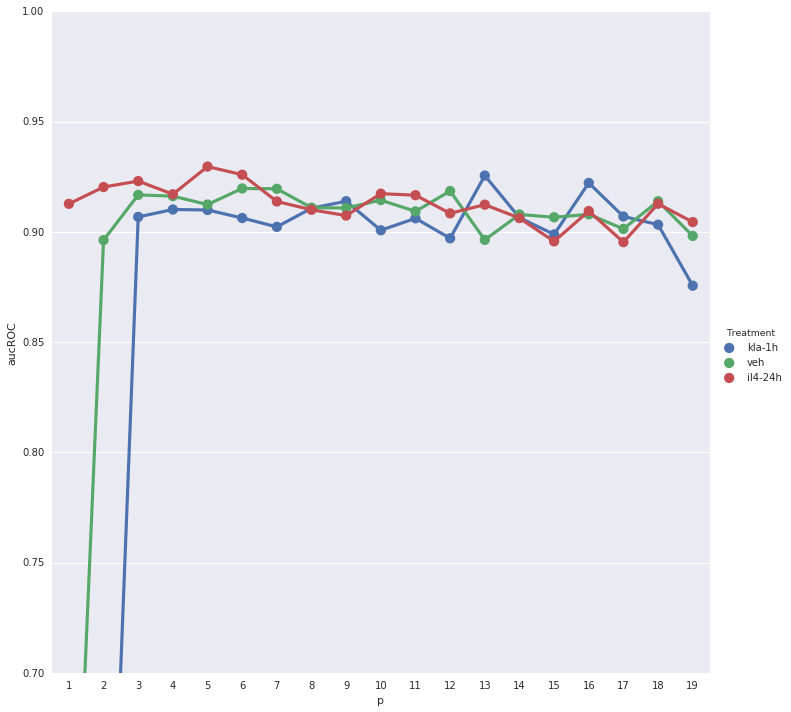

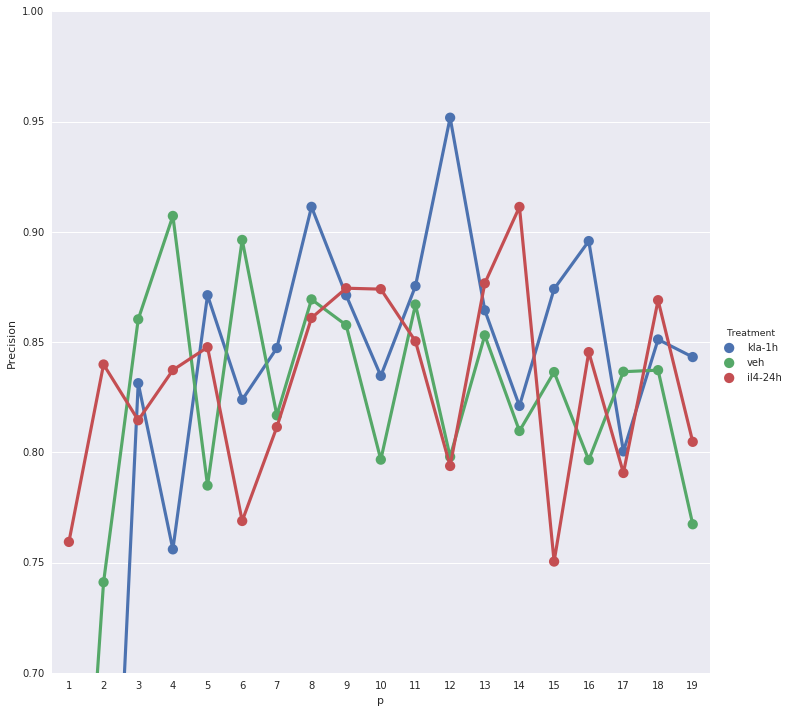

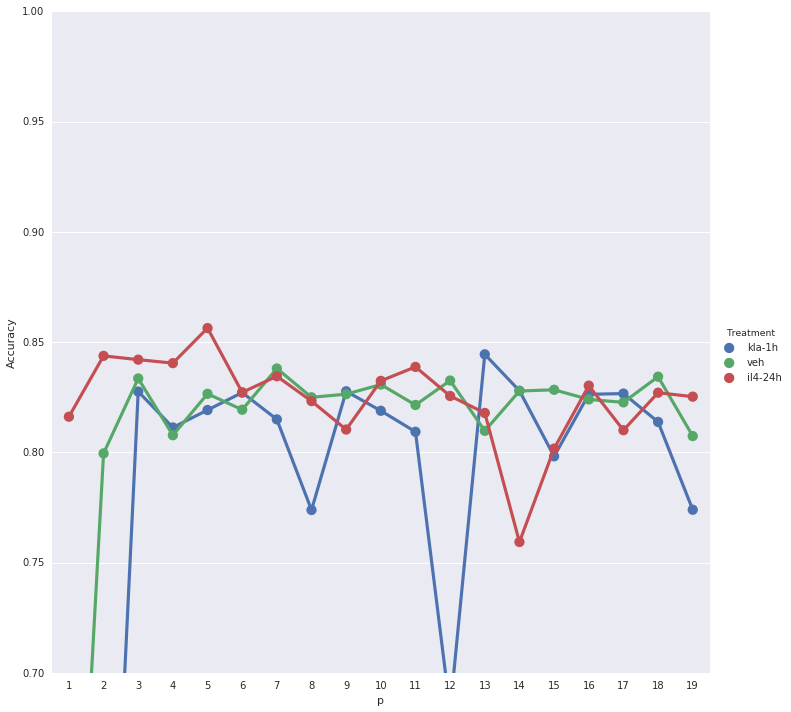

In [342]:
frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'p':p_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments})

sns.factorplot(data = frame, x='p', y='aucROC', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()
sns.factorplot(data = frame, x='p', y='Precision', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()

sns.factorplot(data = frame, x='p', y='Accuracy', hue = 'Treatment', size=10)
plt.ylim(0.7,1)
plt.show()



## Weight Extraction

In [607]:
import numpy as np

import copy
import types as python_types
import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine.base_layer import InputSpec
from keras.engine.base_layer import Layer
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.legacy import interfaces

In [650]:
import tensorflow as tf

In [843]:
def element_multiply (x,y):
    x_shape = []
    for i, s in zip(K.int_shape(x), tf.unstack(tf.shape(x))):
        if i is not None:
            x_shape.append(i)
        else:
            x_shape.append(s)
    x_shape = tuple(x_shape)
    y_shape = []
    for i, s in zip(K.int_shape(y), tf.unstack(tf.shape(y))):
        if i is not None:
            y_shape.append(i)
        else:
            y_shape.append(s)
    y_shape = tuple(y_shape)

    xt = tf.reshape(x, [-1, x_shape[-1],1])
    yt = tf.reshape(y, [y_shape[-2],1])

    return tf.multiply(xt,yt)

class Projection(Layer):
    """
    Learn linear transform of imput tensor
    """
    def __init__(self, units,
                 activation=None,
                 kernel_initializer='glorot_uniform',
                 kernel_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Projection, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      constraint=self.kernel_constraint)

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    
    def call(self, inputs):
        output = element_multiply(inputs, self.kernel)
        
        if self.activation is not None:
            output = self.activation(output)
        
        return output

In [854]:
def get_dotProductAttention_model(total_seq_length,
    seq_size=150,
    num_motifs=32, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    num_dense_neurons=32,
    dropout_rate=0.5):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)
    #print('forward_motif_scores', forward_motif_scores.get_shape())

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)
    #print('cropped_fwd_scores', cropped_fwd_scores.get_shape())

    ### flip motif scores ###
    flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
        output_shape=(seq_size, num_motifs),
        name='flip_layer')
    flipped_rev_scores = flip_layer(cropped_rev_scores)
    #print('flipped_rev_scores', flipped_rev_scores.get_shape())

    ### concatenate motif scores ###
    concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
    concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
    #print('concatenated_motif_scores', concatenated_motif_scores.get_shape())

    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
    #print('pooled_scores', pooled_scores.get_shape())
    
    ### normalize motif scores ###
    motif_score_norm_layer = BatchNormalization(name='motif_score_norm_layer')
    normed_pooled_scores = motif_score_norm_layer(pooled_scores)
    print('normed_pooled_scores', normed_pooled_scores.shape)
        
    ### compute attention ###
    print((int(seq_size/adjacent_bp_pool_size), num_motifs*2))
    ### weight queries ###
    query_transformer = TimeDistributed(Projection(units=1), 
                                        input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                        name='query_transformer'
                                       )
    weighted_queries = query_transformer(normed_pooled_scores)
    print('weighted_queries', weighted_queries.shape)
    
    ### weight keys ###
    key_transformer = TimeDistributed(Projection(units=1), 
                                      input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                      name = 'key_transformer')
    weighted_keys = key_transformer(normed_pooled_scores)
    print('weighted_keys', weighted_keys.shape)
    
    dot_product = Dot(axes=(2,2),name='dot_product')
    attention_weights = dot_product([weighted_queries, weighted_keys])
    #print('attention_weights', attention_weights.shape)
    
    scaling_layer = Lambda(lambda x: x/(int(attention_weights.shape[1])**-2),
        name='scaling_layer')
    scaled_attention_weights = scaling_layer(attention_weights)
    

    ### apply softmax ###
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(scaled_attention_weights)
    #print('attention_softmax_layer_out',attention_softmax_layer_out.shape)
    
    ### weight values ###
    value_transformer = TimeDistributed(Projection(units=1), 
                                        input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                        name='value_transformer'
                                       )
    
    weighted_values = value_transformer(normed_pooled_scores)

    print('weighted_values', weighted_values.shape)
    
    ### attend to hidden states ###
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')
    attended_states = attending_layer([attention_softmax_layer_out, weighted_values])
    print('atteneded_states', attended_states.shape)
    
    ### fully connected layer ###
    dense_layer = Dense(num_dense_neurons, 
        activation='relu', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(attended_states)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'sigmoid', 
                       )(flattened)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [871]:
dotProductAttention_model = get_dotProductAttention_model(200,
    seq_size=150,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=5,
    num_dense_neurons=32,
    dropout_rate=0.5)

normed_pooled_scores (?, 30, 300)
(30, 300)
weighted_queries (?, 30, 300)
weighted_keys (?, 30, 300)
weighted_values (?, 30, 300)
atteneded_states (?, 30, 300)


In [872]:
# SVG(model_to_dot(dotProductAttention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [873]:
# dotProductAttention_model.summary()

In [874]:
dotProductAttention_model.count_params()

19804

In [875]:
dotProductAttention_model.fit([x_train, x_rc_train], y_train,
              batch_size=128,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))

probs = dotProductAttention_model.predict([x_test, x_rc_test])

roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
precision = sklearn.metrics.precision_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], [1 if x > 0.5 else 0 for x in probs[:,1]])
print(roc, precision, acc)

Train on 34841 samples, validate on 8711 samples
Epoch 1/10
34841/34841 [==============================] - 60s 2ms/step - loss: 0.6884 - acc: 0.5323 - val_loss: 0.6758 - val_acc: 0.5750
Epoch 2/10
34841/34841 [==============================] - 26s 760us/step - loss: 0.6344 - acc: 0.6407 - val_loss: 0.7078 - val_acc: 0.5839
Epoch 3/10
34841/34841 [==============================] - 27s 764us/step - loss: 0.5816 - acc: 0.6916 - val_loss: 0.5628 - val_acc: 0.7135
Epoch 4/10
34841/34841 [==============================] - 26s 758us/step - loss: 0.5304 - acc: 0.7340 - val_loss: 0.5728 - val_acc: 0.7114
Epoch 5/10
34841/34841 [==============================] - 26s 756us/step - loss: 0.4858 - acc: 0.7662 - val_loss: 0.6106 - val_acc: 0.6828
Epoch 6/10
34841/34841 [==============================] - 27s 776us/step - loss: 0.4626 - acc: 0.7799 - val_loss: 0.4748 - val_acc: 0.7737
Epoch 7/10
34841/34841 [==============================] - 27s 771us/step - loss: 0.4333 - acc: 0.8009 - val_loss: 0.421

In [876]:
def get_sequence_attention(model, sequence, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                model.get_layer('input_rev').input,
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    fwd_seq = sequence[:200]
    rev_seq = str(Bio.Seq.Seq(fwd_seq).reverse_complement())
    
    fwd_seq_array = convert_sequences_to_array([fwd_seq])[0]
    rev_seq_array = convert_sequences_to_array([rev_seq])[0]

    layer_output = get_attention(([fwd_seq_array], [rev_seq_array], 0))[0]
    reshaped_output = layer_output.reshape((layer_output.shape[1], layer_output.shape[2]))


    full_attention = []
    for x in reshaped_output:
        for i in range(adjacent_bp_pool_size):
            full_attention.append(x)
    full_attention = np.array(full_attention)

    crop_distance = int((len(fwd_seq) - full_attention.shape[0])/2)

    attended_sequence = fwd_seq[crop_distance:-crop_distance]
    return layer_output, full_attention, attended_sequence

In [ ]:
layer_output, full_attention, attended_sequence = get_sequence_attention(dotProductAttention_model,
                                                                         str(positive_seqRecords[100].seq),
                                                                         5)

In [ ]:
full_attention.shape

In [ ]:
attended_sequence

In [ ]:
chunks = []
for i in range(0,len(attended_sequence),5):
    print(i, i+5, attended_sequence[i:i+5])
    chunks.append(attended_sequence[i:i+5])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]), 
    square = True,
    yticklabels = chunks,
    xticklabels=chunks)

In [ ]:
summed_attention = layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]).sum(axis=1)

In [ ]:
summed_attention = summed_attention.reshape((len(summed_attention),1))

In [ ]:
plt.figure(figsize = (10,10))


sns.heatmap(summed_attention.T,
            square = True,
            xticklabels=chunks)

In [582]:
layer_output.sum(axis=1)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
      dtype=float32)